In [117]:
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import itertools
import random
import os

In [140]:
def estimate_rnd_spine_mean_std(k, nt):
    hk, g = k//2, 1 + k**2//4
    scores = []
    
    for _ in range(nt):
        freq = [[0 for j in range(g)] for i in range(g)]

        for i in range(g):
            row = [i for i in range(i)] + [i for i in range(i+1, g)]
            random.shuffle(row)

            for offset in range(0, g-1, hk):
                for j in range(offset, offset + hk):
                    for z in range(j+1, offset + hk):
                        freq[min(row[j], row[z])][max(row[j], row[z])] += 1

        scor = 0
        for i in range(g):
            for j in range(i+1, g):
                scor -= abs(hk-1 - freq[i][j])
        scores.append(scor)
    
    scores = np.array(scores)
    return scores, scores.mean(), scores.std()

In [141]:
ROOT = "/home/vlad/Desktop/Probleme/LaburiDC/dragonfly_scripts/simulate_dfly_queue_sizes"
TRAFFIC_PATTERNS = ["group_incast", "host_incast", "all_to_all"]
BALLS_BINS_STRATEGY = ["greedy1", "greedy2seq", "greedy2par"]
CNT_STEPS = 500
CNT_RUNS = 2

KInfo = namedtuple("KInfo", ["half_k", "cnt_groups", "group_size", "dfly_size", "random_spine_cfg_scores"])
ht_kinfo = {k: KInfo(k//2, 1 + k**2//4, k**2//4 + k, (1 + k**2//4) * (k**2//4 + k), estimate_rnd_spine_mean_std(k, 10**4)[0]) for k in [4, 6, 8]}

In [9]:
for root, dirs, files in os.walk(os.path.join(ROOT, "configs")):
    if len(dirs) == 0:
        for file in tqdm(files):
            cfg_fpath = os.path.join(root, file)
            
            for tp, bb, run_id in itertools.product(TRAFFIC_PATTERNS, BALLS_BINS_STRATEGY, range(1, CNT_RUNS+1)):    
                fpath_out = cfg_fpath.replace("configs", "configs_run_outputs")
                end = f"{fpath_out.split('/')[-1].split('.')[0]}_tp_{tp}_bb_{bb}_run_{run_id}.txt"
                fpath_out = os.path.join('/'.join(fpath_out.split('/')[:-1]), end)
                
                os.system(f"{ROOT}/sim1 {cfg_fpath} {tp} {bb} {CNT_STEPS} > {fpath_out}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1141/1141 [22:18<00:00,  1.17s/it]


In [114]:
ht = {} # {(k, tp, bb): {score: [(mean, std)]}}
for k in [4, 6, 8]:
    for root, dirs, files in os.walk(os.path.join(ROOT, f"configs_run_outputs/k_{k}")):
        for fname in tqdm(files):
            tmp = fname.split('.')[0].split('_')
            score, tp, bb = int(tmp[tmp.index("score") + 1]), '_'.join(tmp[tmp.index("tp") + 1: tmp.index("bb")]), tmp[tmp.index("bb") + 1]
            with open(os.path.join(root, fname)) as fin:
                lines = [line.strip() for line in fin.readlines()]
                group_sums = [0 for _ in range(ht_kinfo[k].cnt_groups)]
                for i in range(0, len(lines), 2):
                    node_id, cnt_qus = map(int, lines[i].split())
                    if cnt_qus > 1: # <=> este switch, nu host.
                        group_id = node_id // ht_kinfo[k].group_size
                        qu_sizes = list(map(int, lines[i+1].split()))
                        
                        group_sums[group_id] += sum(qu_sizes)

                if (k, tp, bb) not in ht:
                    ht[(k, tp, bb)] = {}
                if score not in ht[(k, tp, bb)]:
                    ht[(k, tp, bb)][score] = []
                from_ind = 1 if tp in ["group_incast", "host_incast"] else 0
                ht[(k, tp, bb)][score].append((np.mean(group_sums[from_ind:]), np.std(group_sums[from_ind:])))

for k_tp_bb in ht.keys():
    for score in ht[k_tp_bb].keys():
        ht[k_tp_bb][score] = (np.mean([m for m, s in ht[k_tp_bb][score]]), np.mean([s for m, s in ht[k_tp_bb][score]]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20538/20538 [00:18<00:00, 1095.15it/s]


In [175]:
def plot_k_tp_bb(ax, ax_inds, ht, k, tp, bb):
    sorted_scores = sorted(ht[(k, tp, bb)].keys())
    for i, name in zip(range(2), ["mean", "std"]):
        l, r = ax_inds[i]
        sorted_vals = [ht[(k, tp, bb)][score][i] for score in sorted_scores]
        ax[l, r].plot(sorted_scores, sorted_vals)
        
        hval, hedg = np.histogram(ht_kinfo[k].random_spine_cfg_scores, bins = "auto")
        rap = max(sorted_vals) / max(hval)
        ax[l, r].stairs(hval * rap, hedg, fill = True, alpha = 0.4)
        
        if l == 0:
            j = np.argmax(hval)
            ax[l, r].text(hedg[j+1], hval[j] * rap * 0.9, "random\nspine config\ndistribution", bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax[l, r].yaxis.get_major_formatter().set_scientific(False)
        ax[l, r].yaxis.get_major_formatter().set_useOffset(False)
        ax[l, r].set_title(f"K = {k}, traffic pattern = {tp}, balls/bins strategy = {bb}")
        ax[l, r].set_xlabel("Topology symmetry score (higher is closer to symmetry)")
        ax[l, r].set_ylabel(f"EV({name} of sum(switch queue sizes)\nover all groups)")

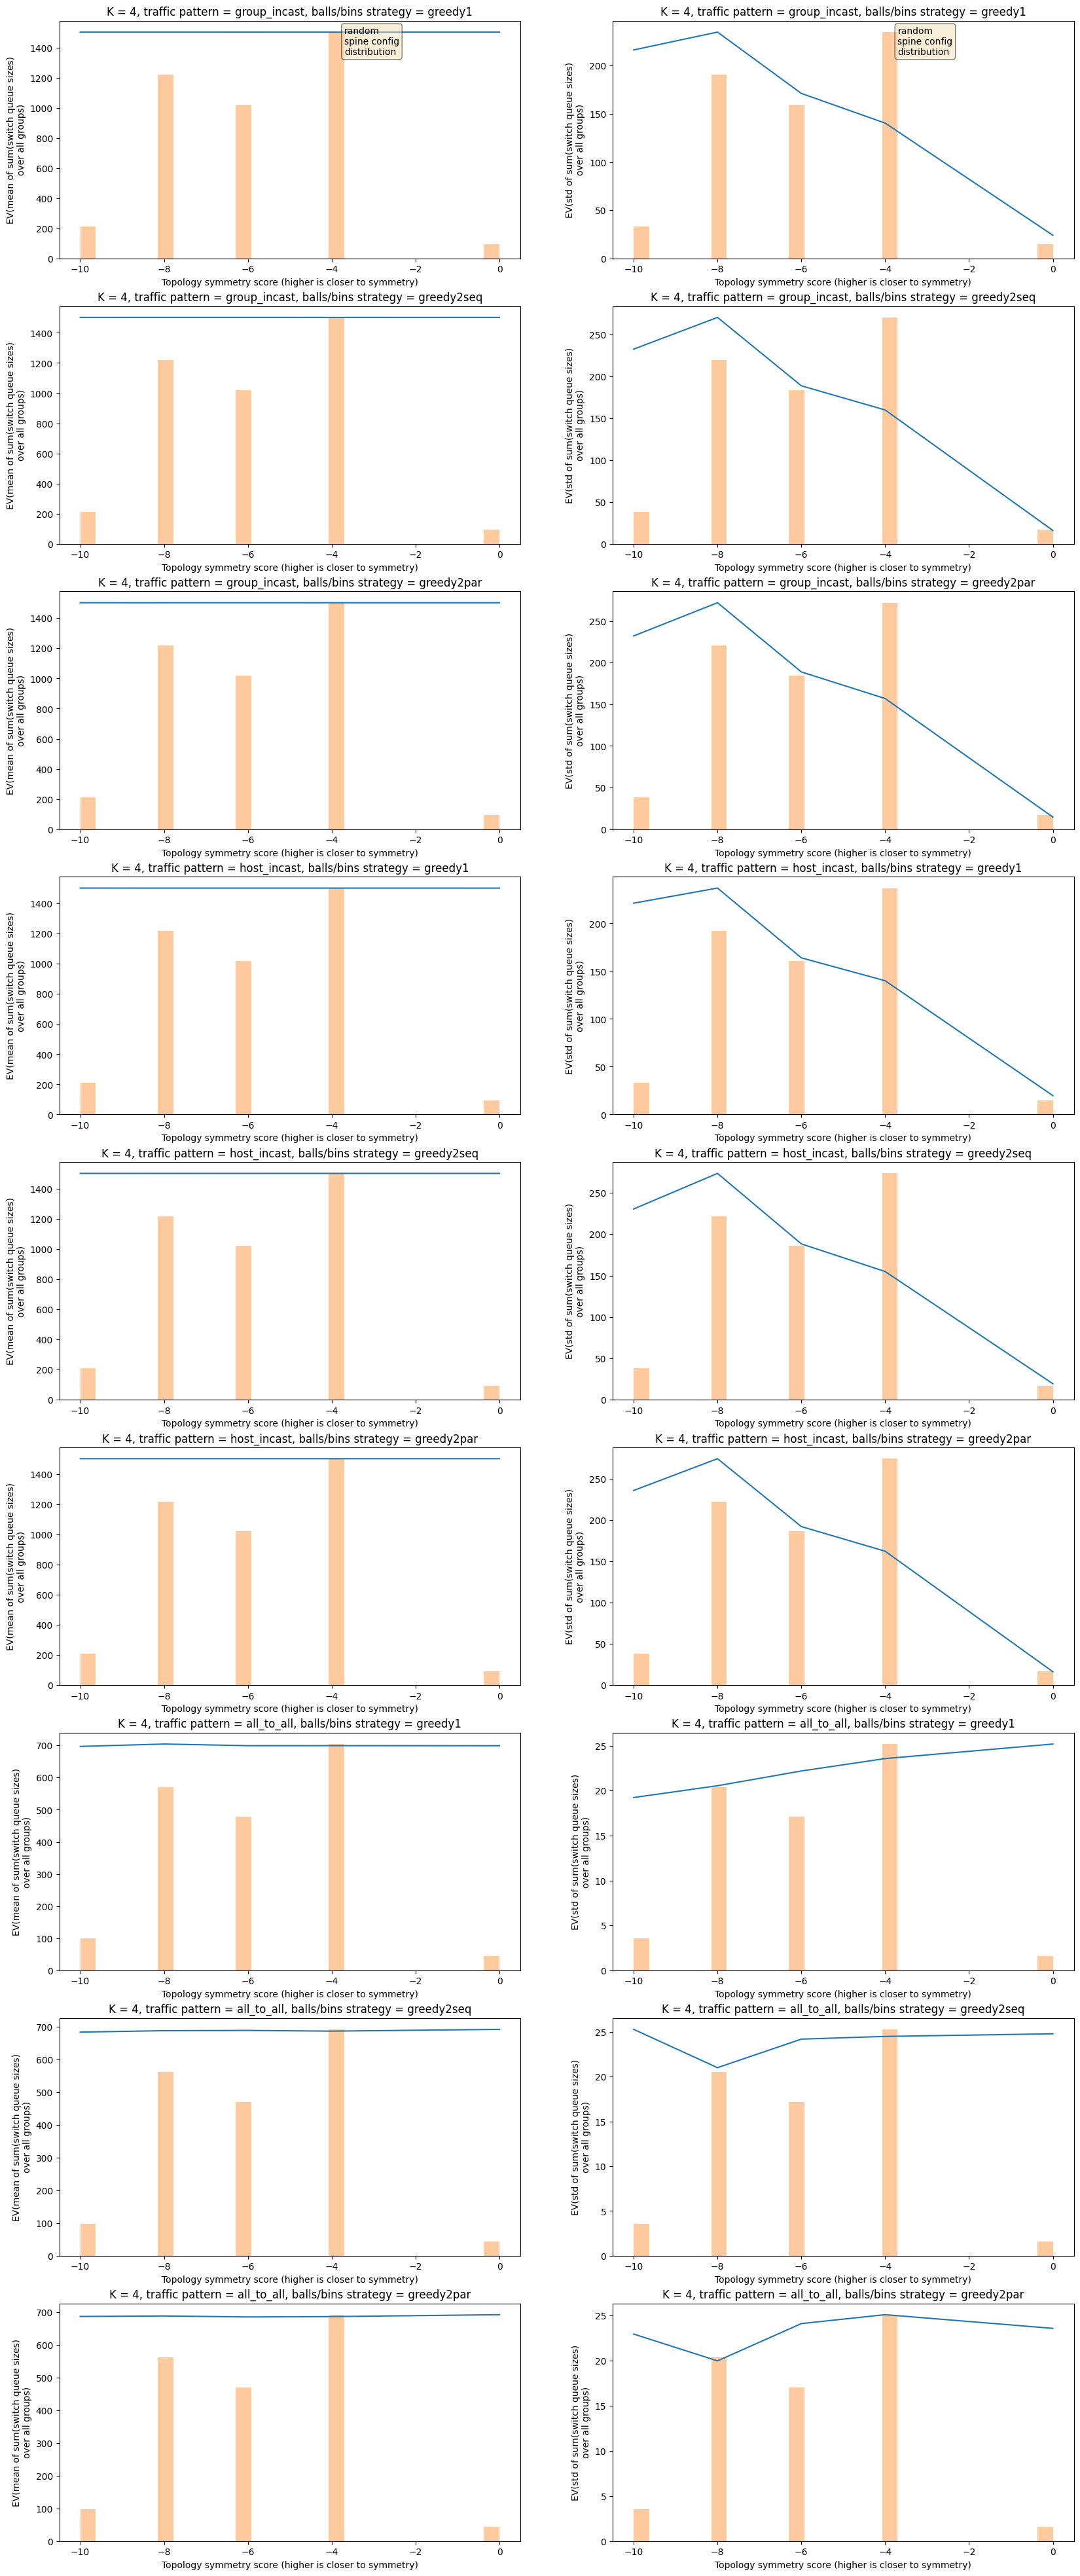

In [176]:
k = 4
fig, ax = plt.subplots(9, 2, figsize = (20, 50))
i = 0
for tp, bb in itertools.product(TRAFFIC_PATTERNS, BALLS_BINS_STRATEGY):
    plot_k_tp_bb(ax, [(i, 0), (i, 1)], ht, k, tp, bb)
    i += 1

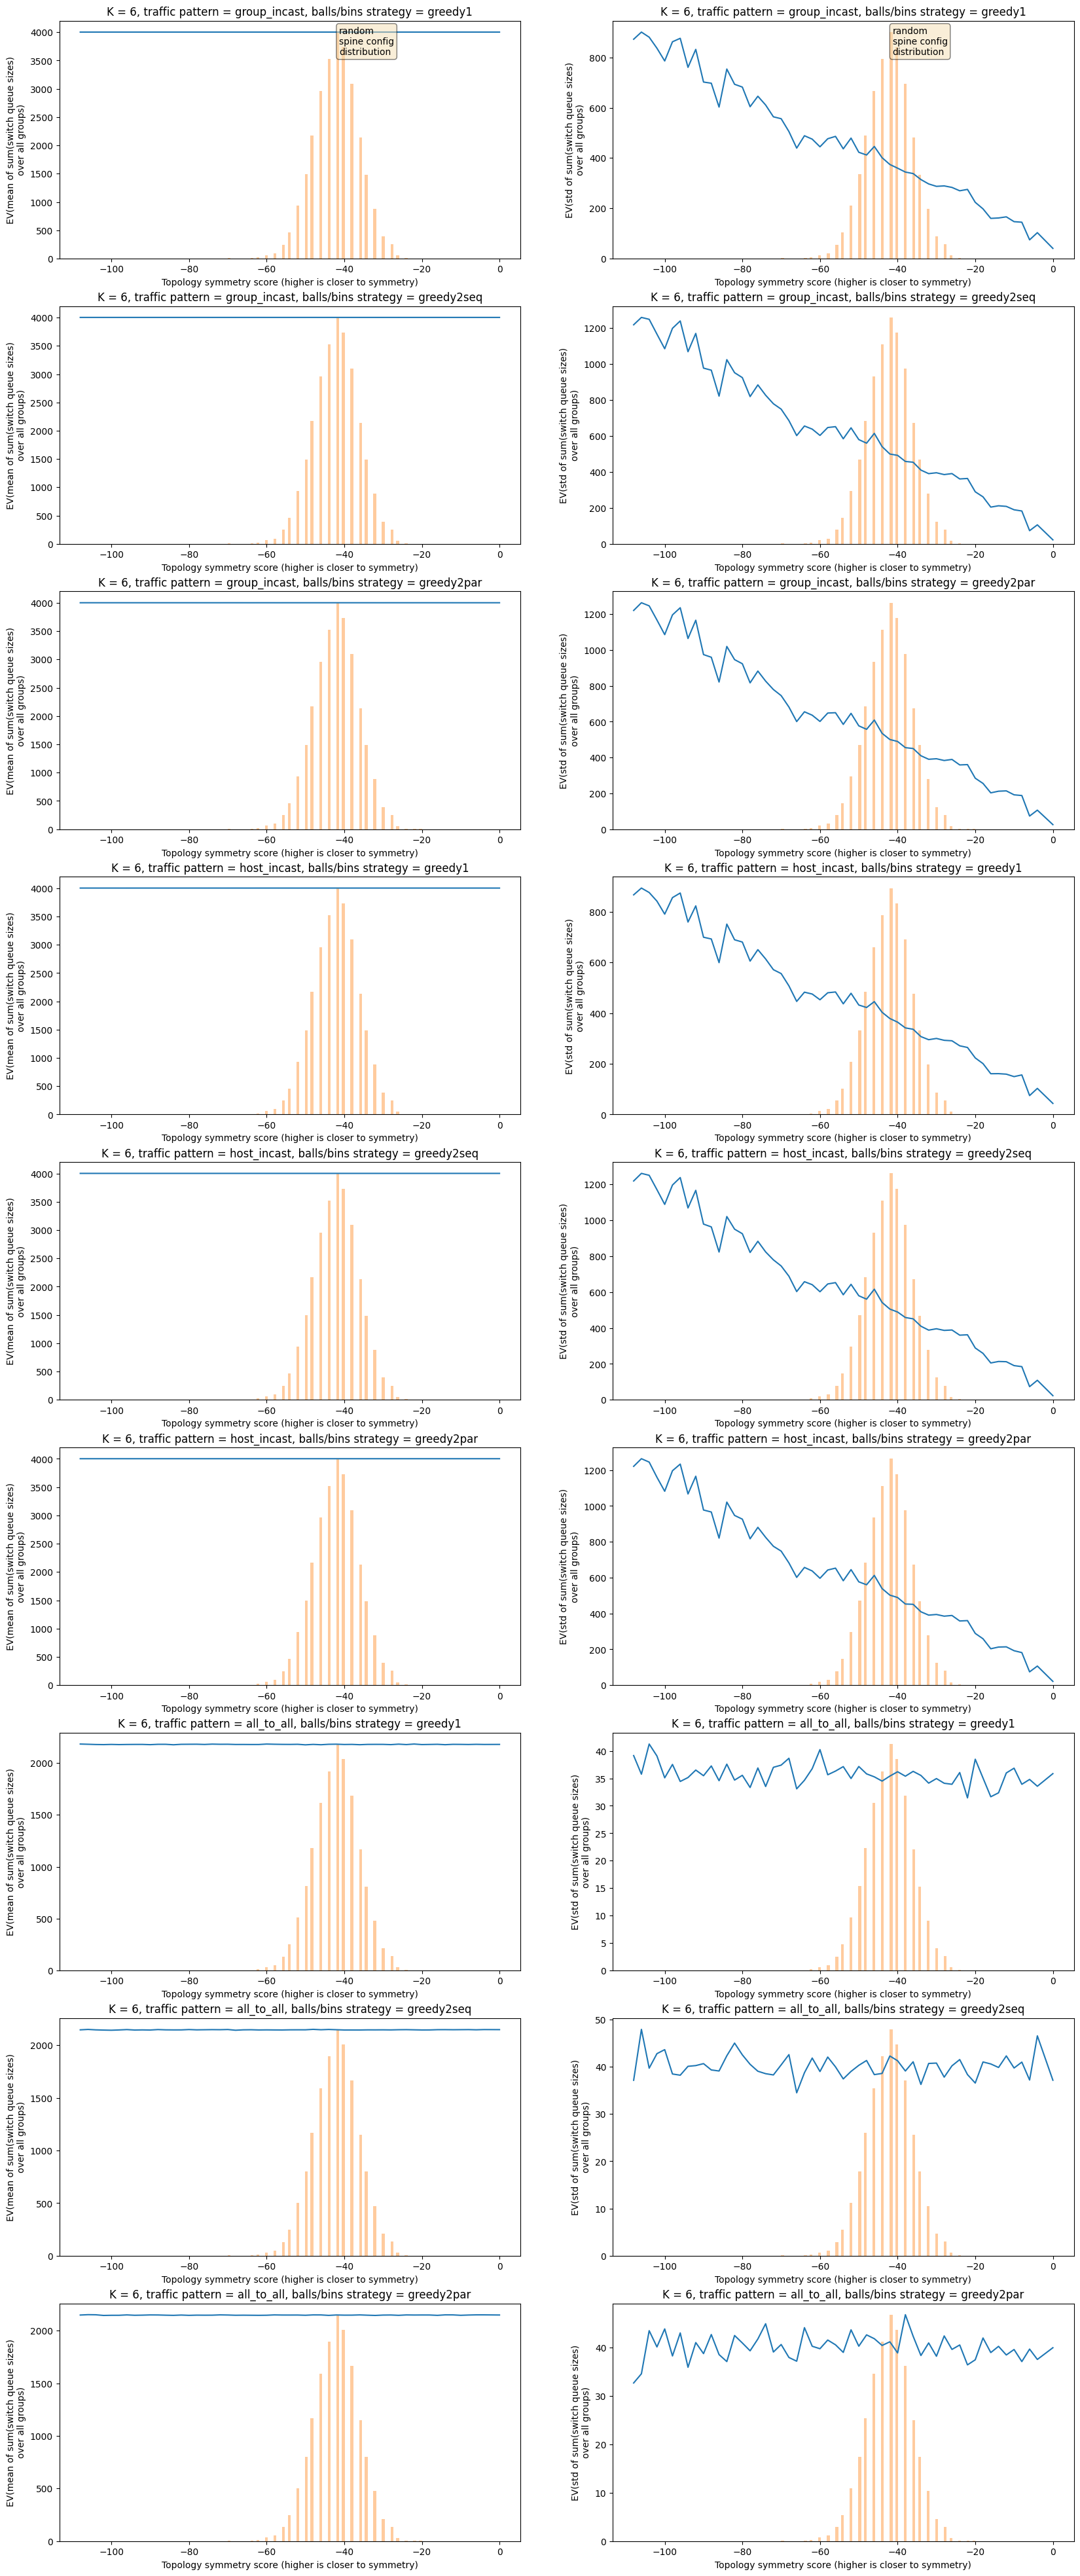

In [177]:
k = 6
fig, ax = plt.subplots(9, 2, figsize = (20, 50))
i = 0
for tp, bb in itertools.product(TRAFFIC_PATTERNS, BALLS_BINS_STRATEGY):
    plot_k_tp_bb(ax, [(i, 0), (i, 1)], ht, k, tp, bb)
    i += 1

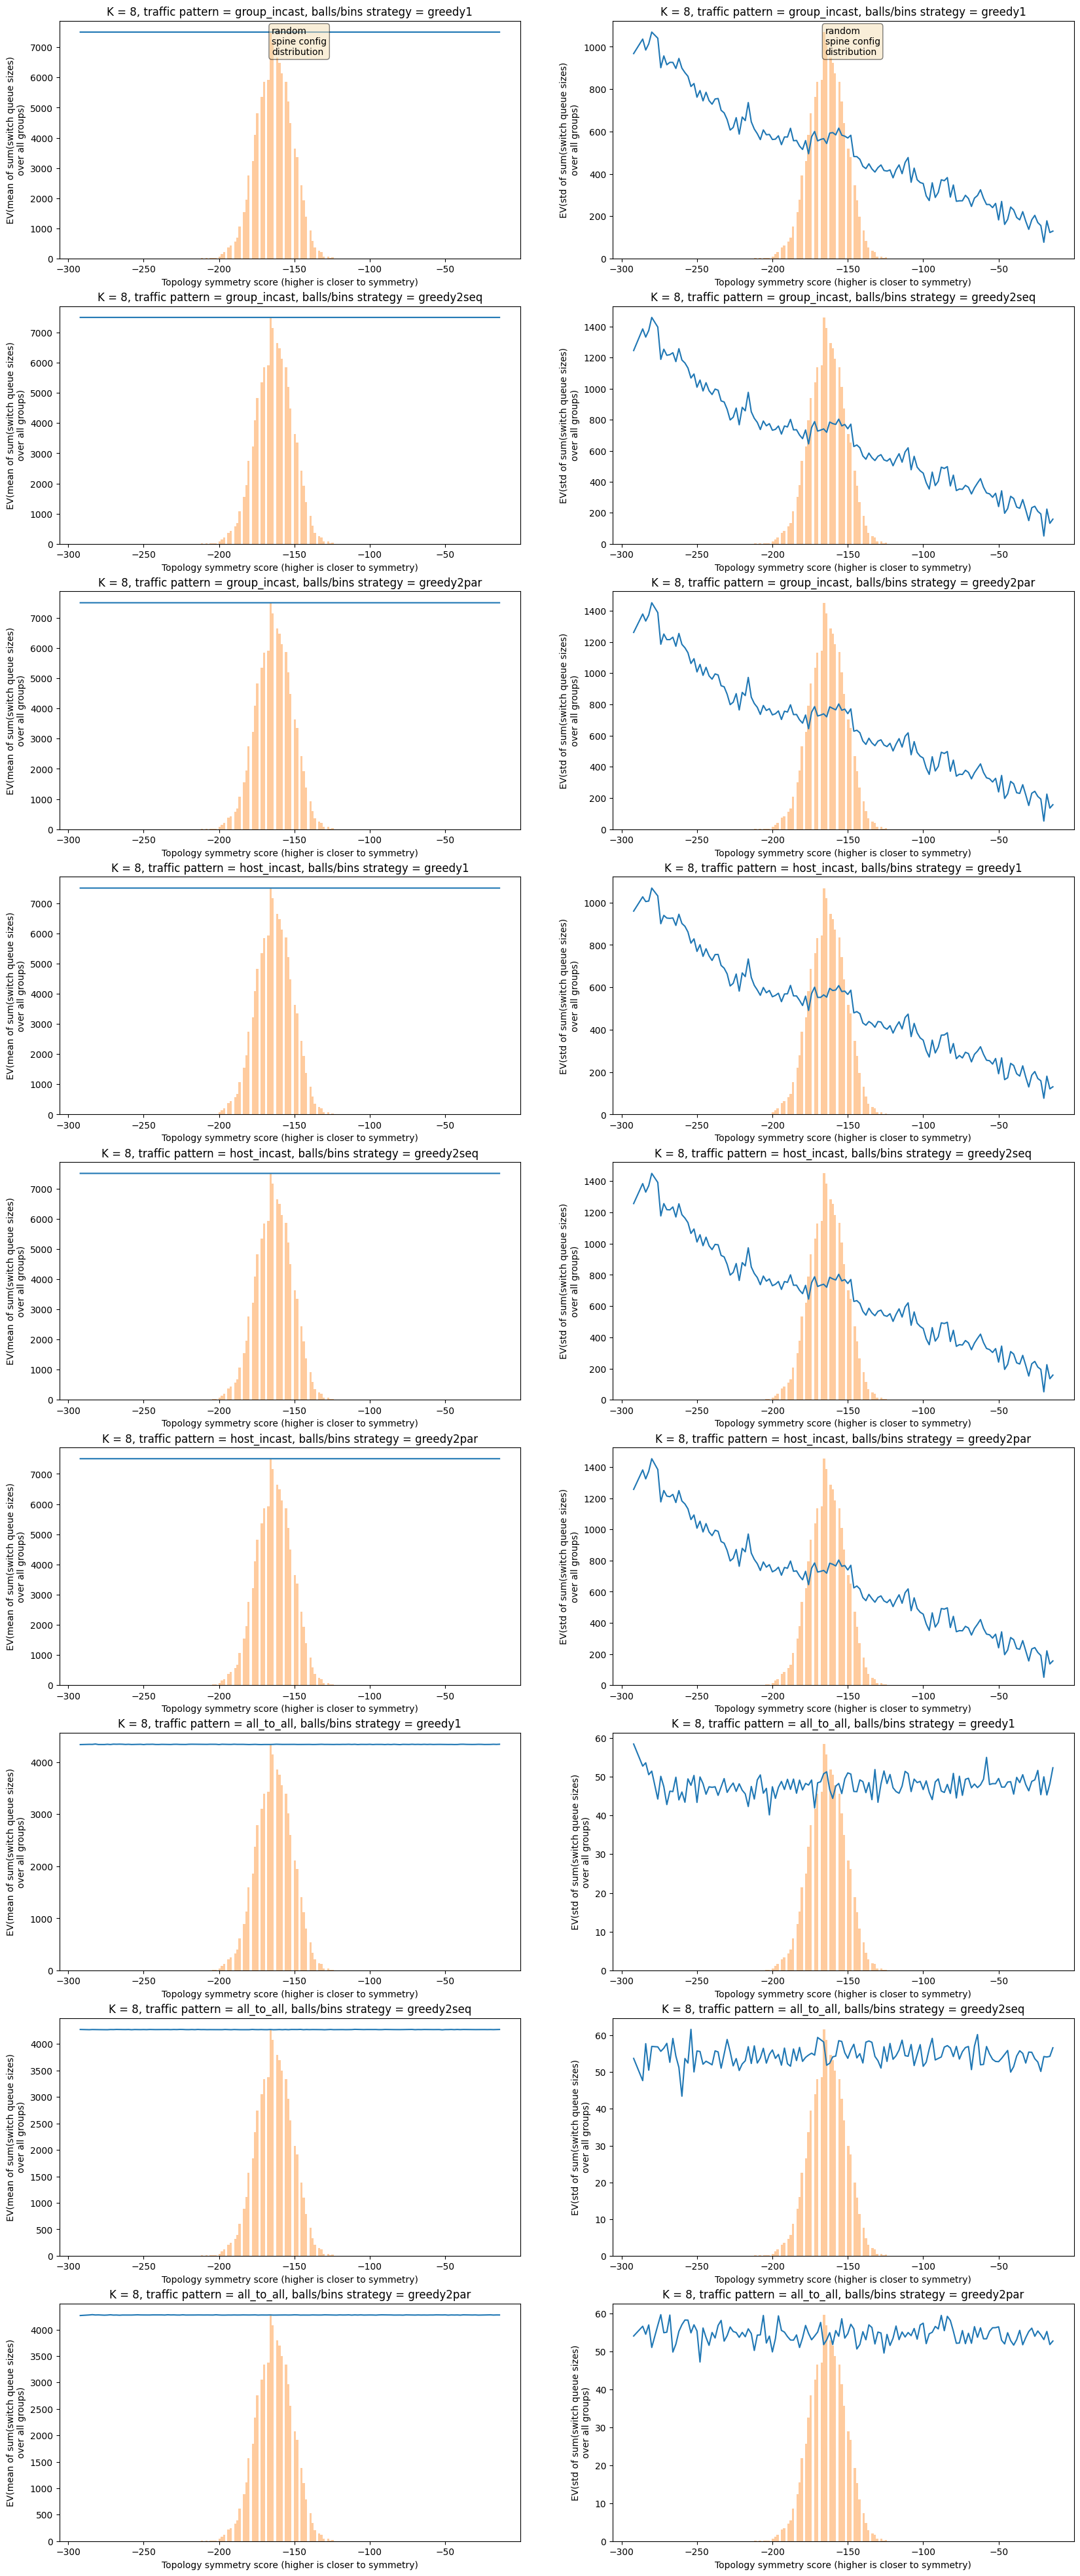

In [178]:
k = 8
fig, ax = plt.subplots(9, 2, figsize = (20, 50))
i = 0
for tp, bb in itertools.product(TRAFFIC_PATTERNS, BALLS_BINS_STRATEGY):
    plot_k_tp_bb(ax, [(i, 0), (i, 1)], ht, k, tp, bb)
    i += 1